In [1]:
%config IPCompleter.greedy=True
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from pandas import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random

In [3]:
data_tr = pd.read_csv("StoresData/Input.csv", parse_dates= True, low_memory= False, index_col= 'Date')

In [4]:
data_st = pd.read_csv("StoresData/Stores_data.csv", low_memory= False)

In [5]:
data_tr.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

In [6]:
print("Total dataset", data_tr.shape)
data_tr.head()

Total dataset (1017209, 8)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [7]:
data_tr['Year'] = data_tr.index.year
data_tr['Month'] = data_tr.index.month
data_tr['Day'] = data_tr.index.day
data_tr['WeekOfYear'] = data_tr.index.weekofyear

data_tr['SalePerCustomer'] = data_tr['Sales']/data_tr['Customers']
data_tr['SalePerCustomer'].describe()



count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

In [8]:
#handling missing values
data_tr[(data_tr.Open == 0) & (data_tr.Sales == 0)].head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-31,876,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-30,292,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-30,876,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-29,292,3,0,0,0,1,0,1,2015,7,29,31,NaN


In [9]:
no_sales = data_tr[(data_tr.Open != 0) & (data_tr.Sales == 0)]
print("Total data with no sales", no_sales.shape)
no_sales.head()

Total data with no sales (54, 13)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-05-15,971,5,0,0,1,0,0,1,2015,5,15,20,NaN
2015-03-26,674,4,0,0,1,0,0,0,2015,3,26,13,NaN
2015-02-05,699,4,0,0,1,1,0,0,2015,2,5,6,NaN
2014-10-01,708,3,0,0,1,1,0,0,2014,10,1,40,NaN
2014-09-22,357,1,0,0,1,0,0,0,2014,9,22,39,NaN


In [10]:
print("""Removing no sales of the stores while store is open from our data set""")
data_tr = data_tr[(data_tr["Open"] != 0) & (data_tr["Sales"] != 0)]
print("Now total dataset becomes", data_tr.shape)
data_tr.head()

Removing no sales of the stores while store is open from our data set
Now total dataset becomes (844338, 13)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31,9.482883
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31,9.702400
2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31,10.126675
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31,9.342457
2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31,8.626118


In [11]:
data_st.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [12]:
#analysing missing values in store information
data_st.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [13]:
data_st[pd.isnull(data_st.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [14]:
data_st['CompetitionDistance'].fillna(data_st['CompetitionDistance'].median(), inplace=True)

In [15]:
no_promo = data_st[pd.isnull(data_st.Promo2SinceWeek)]
no_promo[no_promo.Promo2 != 0].shape

(0, 10)

In [16]:
data_st.fillna(0, inplace = True)

In [17]:
#merging our store information with our training dataset
tr_st = pd.merge(data_tr, data_st, how = "inner", on = "Store")
print("After merging, total dataset ", tr_st.shape)
tr_st.head()

After merging, total dataset  (844338, 22)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


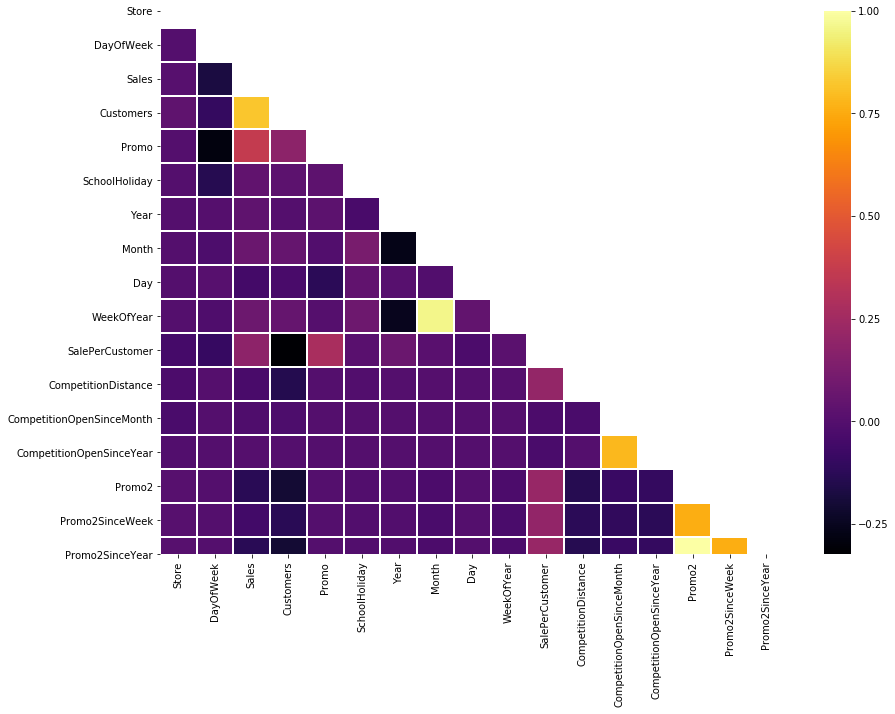

In [49]:
corr_all = tr_st.drop("Open", axis=1).corr()
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize = (14, 10))
sns.heatmap(corr_all, mask= mask,linewidths= 1, ax=ax, cmap="inferno")

In [50]:
print("""Strong Correlation analysis found in Customers and Sales, 
        while in case for promo it shows a weak correlation""")

Strong Correlation analysis found in Customers and Sales, 
        while in case for promo it shows a weak correlation


In [18]:
#getting sales of each store type
tr_st.groupby('StoreType')['Customers', 'Sales'].sum()

,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


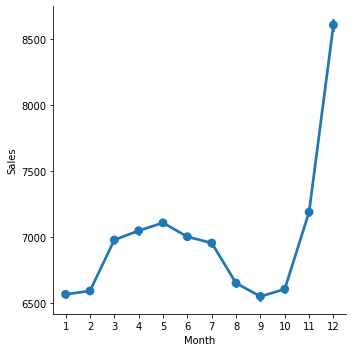

In [34]:
#plotting a graph of sales trends by year
sns.factorplot(data = tr_st, x = 'Month', y='Sales')

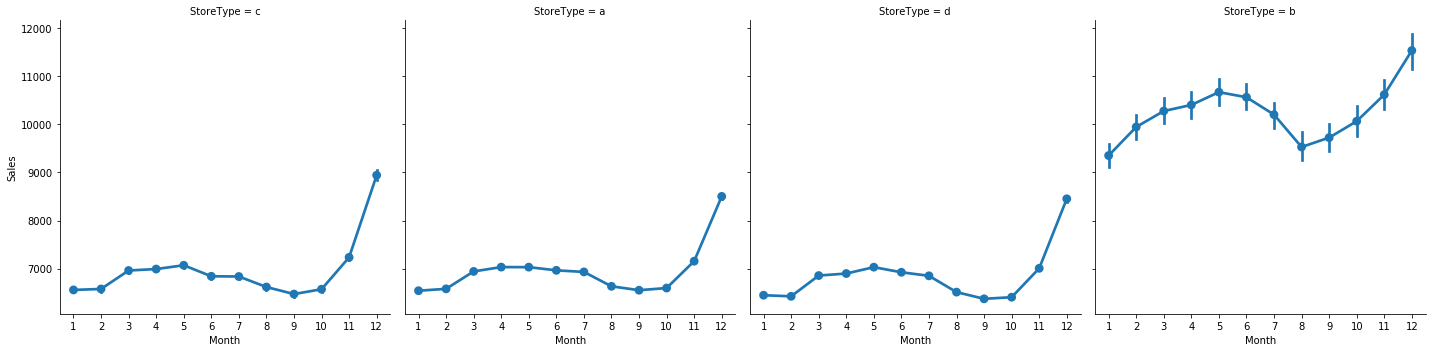

In [25]:
#plotting a graph for sales of each store type 
sns.factorplot(data = tr_st, x = 'Month', y='Sales', col='StoreType')

In [29]:
tr_st.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


In [30]:
print("""Thus according to the above analysis, Store type b tends towards more sales but on the 
      other hand we have less records for store b as compared to others""")

Thus according to the above analysis, Store type b tends towards more sales but on the 
      other hand we have less records for store b as compared to others


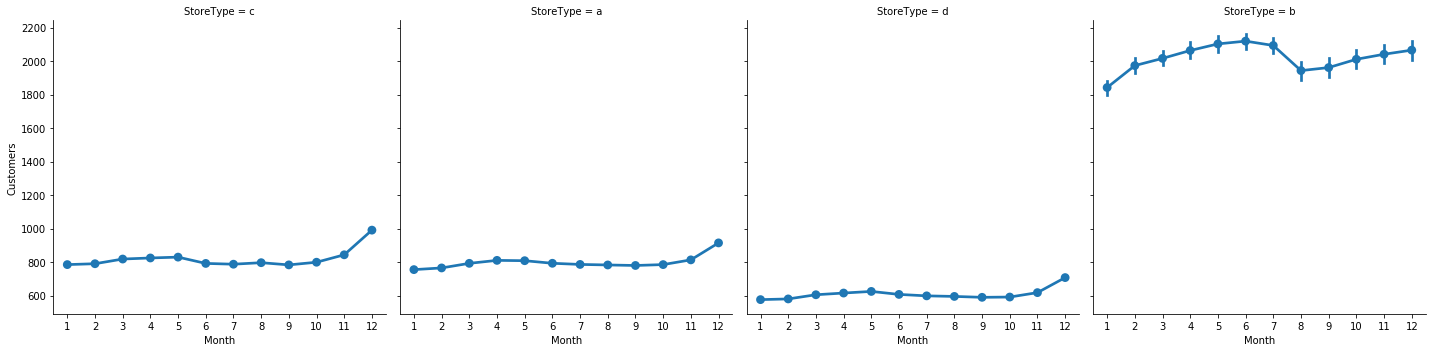

In [27]:
#customer trends
sns.factorplot(data = tr_st, x="Month", y="Customers", col="StoreType")

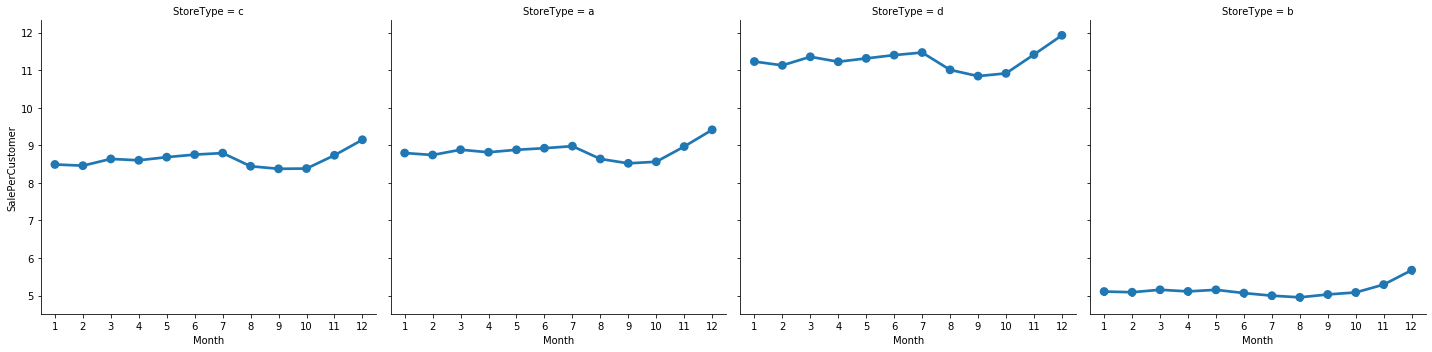

In [32]:
#salespercustomer graph
sns.factorplot(data = tr_st, x="Month", y="SalePerCustomer", col="StoreType")

In [33]:
print("""By the above analysis most of the Sales/Customer values goes for StoreType d, 
it means customers tends to buy expensive products froms store d""")

By the above analysis most of the Sales/Customer values goes for StoreType d, 
it means customers tends to buy expensive products froms store d


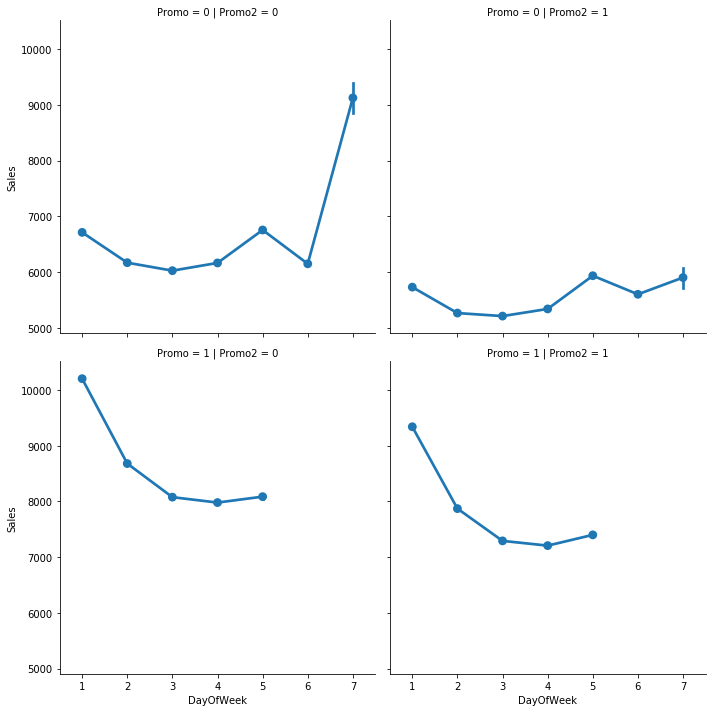

In [55]:
#analysis in case for promo, how sales depend when promo, promo2 is 1 or 0
sns.factorplot(data= tr_st, x='DayOfWeek', y='Sales', row="Promo", col="Promo2")

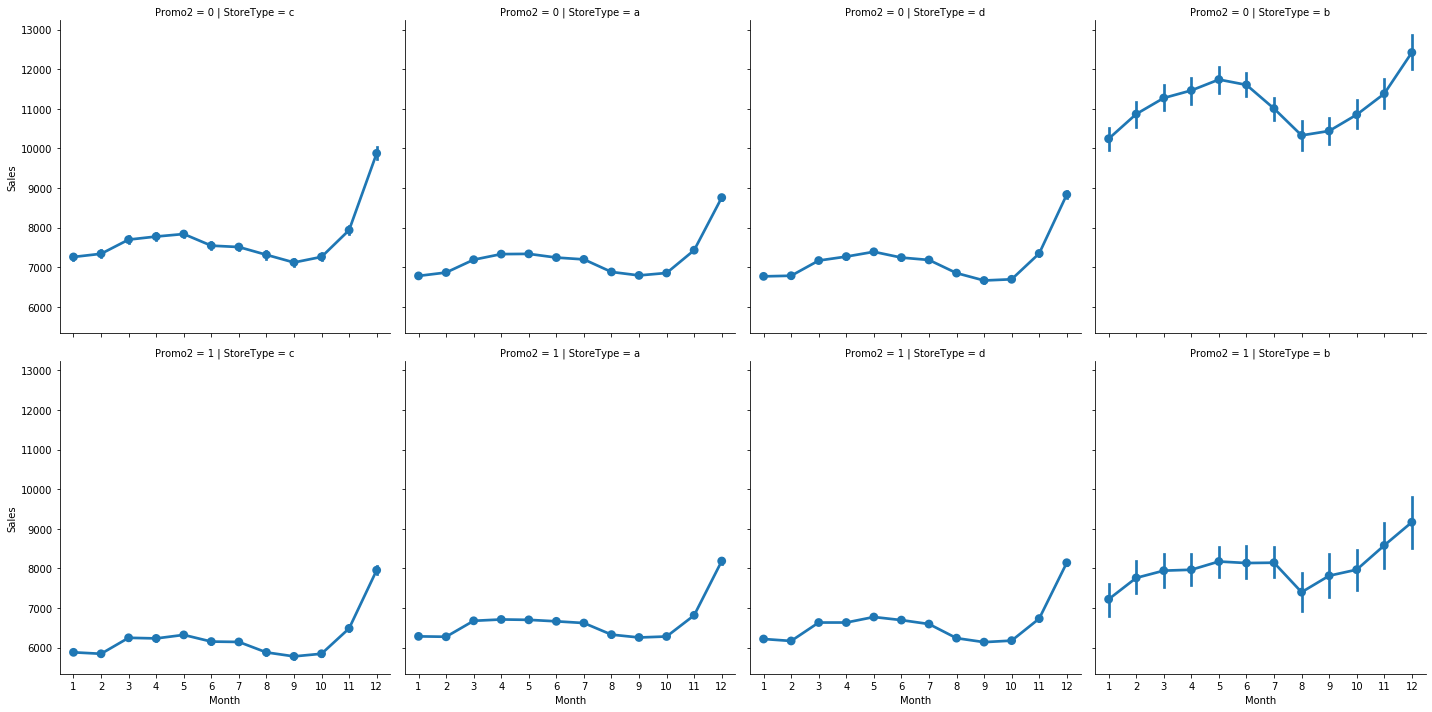

In [58]:
sns.factorplot(data= tr_st, x='Month', y='Sales', row="Promo2", col="StoreType")